### In this file I want to compare a NN with an SHG layer to the one with a SHG/DOPA activation

In [5]:
import numpy as np 
import pandas as pd
import os, time, sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten # type: ignore

import dnn
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
import scipy.special as sp
from scipy.optimize import fsolve
def analytics(input_FH, input_SH, lam1=1.064e-6,
            n1=2.1, n2=2.1, d_eff=(20e-12)*(2/np.pi),
             L=10e-3, N_z=1000):
    """ 
    Parameters:
    input_FH[complex64]: input value of the fundamental harmonic
    input_SH[complex64]: input value of the second  harmonic
    lam[float]     : FH wavelength in units of m
    L[float]        : total crystal length in units of m
    n1[float]       : refractive index of the material at the FH wavelength
    n2 [float]      : refractive index of the material at the SH wavelength, if n2 = n1 the system is phasematched
    d_eff[float]    : effective nonlinearity in units of m/V, look at boyd eq (2.4.3) for effective d with QPM
    N_z[int]        : number of sampling points
    
    Returns:
    output_FH[complex64]: output value of the fundamental harmonic

    Function implements the analytical solution of the coupled
    mode equations for SHG in a bulk crystal. The solution is based on the elliptic
    Jacobi function and is taken from https://doi.org/10.1103/PhysRev.127.1918. 
    This solution is valid for any phase mismatch for the input beams 
    as long as Δk=0.

    """
    def equation(u):
        return sp.ellipj(u, gamma)[0] - sn_value_0  # Extract the sn(u, m) value
    #constants
    c=3e8                       #speed of light in m/s
    epsilon_0=8.854187817e-12   #vacuum permittivity in F/m
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    

    z= L 
    u0=np.abs(input_FH)
    v0=np.abs(input_SH)
    phi1_0=np.angle(input_FH)
    phi2_0=np.angle(input_SH)
    
    
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    if 2*k1-k2!=0:  #should alway be zero otherwise the analytics doesn't work
        print('Analytics cannot be found because Δk!=0')
        return 

    
    #constants for our analytical solution
    Gamma=u0**2*v0*np.cos(2*phi1_0-phi2_0)
    sign=np.sign(np.sin(2*phi1_0-phi2_0)) #this sign determines the sign of the integration constant z0
    
    #finding roots of the third order polynomial equation on the right side of the differential equation
    coeffs=[1, -2,1,-Gamma**2]
    roots=np.roots(coeffs)
    va2, vb2, vc2 = np.round(np.real(np.sort(roots)), 14)
    gamma=(vb2-va2)/(vc2-va2)
    #getting constants of integration
    if np.round(v0**2,6)==np.round(va2,6):
        va2=v0**2
    sn_value_0=np.sqrt((v0**2-va2)/(vb2-va2))
    z0_guess=1.
    u=fsolve(equation, z0_guess)[0]
    z0=1/np.sqrt(vc2-va2)*u

    #the analytical solution for amplitudes
    v2=va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 #amplitude squared of SH
    u2=1-v2

    u=np.sqrt(u2)
    v=np.sqrt(v2)

    theta0=2*phi1_0-phi2_0

    #SHG for theta0=3pi/2
    #phi1=phi1_0+0.5*u0**2*v0*np.cos(theta0)*(z-sign*z0+np.cosh(z-sign*z0)*np.sinh(z-sign*z0)+sign*z0-np.cosh(-sign*z0)*np.sinh(-sign*z0))
    #phi2=phi2_0+u0**2*v0*np.cos(theta0)*(z-sign*z0-np.cosh(z-sign*z0)/np.sinh(z-sign*z0)+sign*z0+np.cosh(-sign*z0)/np.sinh(-sign*z0))
    #print(phi1_0, phi2_0, phi1[0], phi2[0], z[0])

    #general case of theta
    def func_sh(z):
        return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
    def func_fh(z):
        return 1/(1-va2-(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 )
    
    
    if isinstance(z, np.ndarray):
        phi1=np.zeros_like(u)
        phi2=np.zeros_like(v) 
        for i,l in enumerate(z):
            
            #phi1_value=c01+u0**2*v0*np.cos(theta0)*integral_fh(l)
            x_values = np.linspace(0, l, 200)
            y_sh=func_sh(x_values)
            y_fh=func_fh(x_values)
            integral_fh = np.trapz(y_fh, x_values)
            integral_sh = np.trapz(y_sh, x_values)
            if (np.cos(theta0)==0) or (u0==0) or (v0==0):
                phi1_value=phi1_0   
                phi2_value=phi2_0   
            else:
                phi1_value=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
                phi2_value=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh
            phi1[i]=phi1_value
            phi2[i]=phi2_value
    else:
        l=z
        x_values = np.linspace(0, l, 200)
        if (np.cos(theta0)==0) or (u0==0) or (v0==0):
            phi1=phi1_0   
            phi2=phi2_0
        else:
            y_sh=func_sh(x_values)
            y_fh=func_fh(x_values)
            integral_fh = np.trapz(y_fh, x_values)
            integral_sh = np.trapz(y_sh, x_values)
            phi1=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
            #theta=np.arccos(u0**2*v0*np.cos(theta0)/(u2*v))
            #phi2=2*phi1-theta
            phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh

    
    u=u*np.exp(1j*phi1)
    v=v*np.exp(1j*phi2)
    

    return u, v

### defining the models with different activation functions

In [9]:
# SHG activation function 
def get_model_FFT_SHG(x,y, Dmeta, loss, metric, detector, z=30, lam=1, Nmeta=56, SHG=True, embedding=0, lr=0.001):
    #padding the input
    N=len(x)
    pad=int((N-28)//2)
    padding=[[0,0], [pad,pad], [pad, pad]]

    #defining the model
    input_layer=Input(shape=(28, 28))
    out=tf.pad(input_layer, padding)
    out=tf.cast(out, tf.complex64)
    out=dnn.opticalFFT(x=x, y=y, lam=lam, f=None)(out)
    out=dnn.Meta(x=x, y=y, lam=lam, Dx_meta=Dmeta, Dy_meta=Dmeta, N_Neurons=Nmeta, embedding=embedding)(out)
    if SHG:
        #free space propagation is default RS
        out=dnn.FreeSpacePropagation(x=x, y=y, z=z, lam=lam)(out)
        out=dnn.Activation.SHG(out)
    out=dnn.opticalFFT(x=x, y=y, lam=lam, f=None)(out)
    output_layer=dnn.ToDetector(detector)(out)
    #build the model
    model=Model(inputs=input_layer, outputs=output_layer, name='model')

    #compile model 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=loss,
        metrics=[metric]
    )
    return model


Shape of Training and test Data
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
Number of classes 10

After one Hot encoding of test labels, with and without mock class
(60000, 11) (60000, 10)


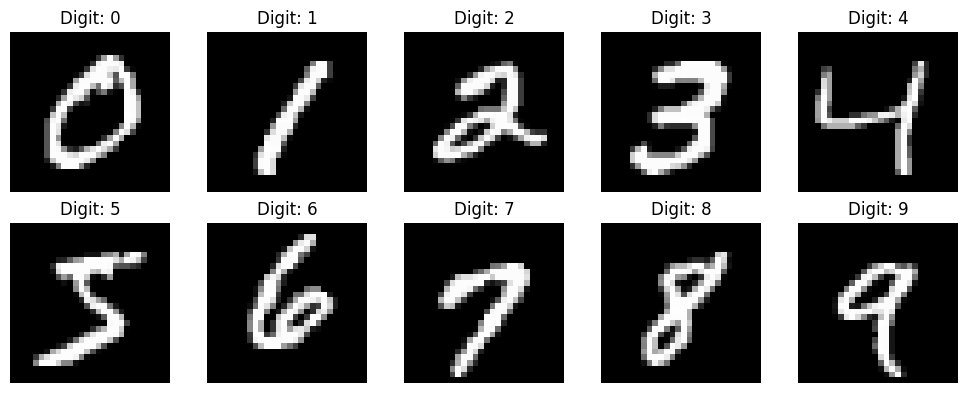

In [31]:
# choosing the data and defining training and validation data

import importlib
importlib.reload(dnn)
#load datasets
x_train, y_train, x_test, y_test =dnn.loadData('digits')
print("\nShape of Training and test Data")
print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))

num_classes=len(np.unique(y_test))
print(f"Number of classes {num_classes}")
y_train_oneHot_withMock = tf.one_hot(tf.cast(y_train,tf.int32), depth=num_classes+1)
y_test_oneHot_withMock  = tf.one_hot(tf.cast(y_test,tf.int32), depth=num_classes+1)
y_train_oneHot_noMock = tf.one_hot(tf.cast(y_train,tf.int32), depth=num_classes)
y_test_oneHot_noMock  = tf.one_hot(tf.cast(y_test,tf.int32), depth=num_classes)
print("\nAfter one Hot encoding of test labels, with and without mock class")
print(np.shape(y_train_oneHot_withMock), np.shape(y_train_oneHot_noMock ))
# Collect one sample per digit
unique_digits = {label: x_train[np.where(y_train == label)[0][0]] for label in range(10)}
# Plot in a 2x5 grid
plt.figure(figsize=(10, 4))
for i, (label, img) in enumerate(unique_digits.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Digit: {label}")
    plt.axis('off')
    if i==9:
        break
plt.tight_layout()
plt.show()


In [32]:
# Choose Model parameters
lam  = 1
D    = 150                             # Here I define Everything in units of lambda, but real units can be used
N    = 2*D                             # Use 2 points per lambda for far-field propagation (more if you look at the near field o correctly show high frequency components)
x = y = np.linspace(-D/2, D/2, N)      # This defines the computational domain 
Dmeta =  0.4*D                         # The metasurface will outomatically be embedded into the computational domain
pixelsize = 1*lam                      # make sure that the pixelsize is not smaller than the sampling, it is best to choose a common multiple to avoid any interpolation
Nmeta = int(Dmeta/pixelsize)      
embedding = 0       
print("Numer of Neurons:", Nmeta)    


Numer of Neurons: 60


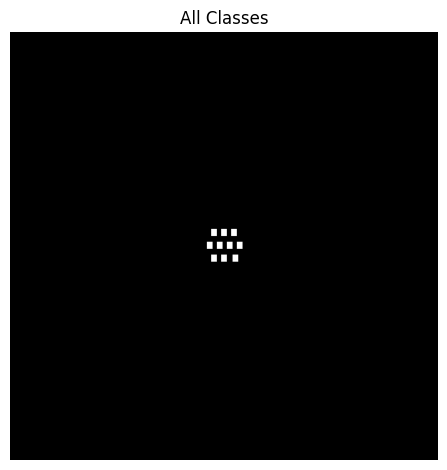

300 120
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.compat.v1.pad (TFOpLamb  (None, 300, 300)          0         
 da)                                                             
                                                                 
 tf.cast (TFOpLambda)        (None, 300, 300)          0         
                                                                 
 optical_fft (opticalFFT)    (None, 300, 300)          0         
                                                                 
 meta (Meta)                 (None, 300, 300)          6272      
                                                                 
 optical_fft_1 (opticalFFT)  (None, 300, 300)          0         
                                                     

In [54]:
importlib.reload(dnn)
# define the model
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric=tf.keras.metrics.SparseCategoricalAccuracy()

#defining the detector
DDet     = 28/N*D 
file     = os.path.join(os.getcwd(),'detector_masks',"10_classes_standard.npy")
detector = dnn.loadDetector(Dx = DDet, Dy = DDet, x = x, y = y, file = file)
#plotting the detector
# Plot the sum over all classes
plt.figure()
plt.imshow(np.sum(detector, axis=0), cmap='gray')  # sum over class axis
plt.axis('off')
plt.title("All Classes")
plt.tight_layout()
plt.show()

tf.keras.backend.clear_session()
model=get_model_FFT_SHG(x=x, y=y, 
                        Dmeta=Dmeta, 
                        loss=loss, 
                        metric=metric, 
                        detector=detector, 
                        z=30, lam=1, Nmeta=56, 
                        SHG=False, embedding=embedding, lr=0.001)
model.summary()

In [55]:
#training with sparse categorical accuracy loss
importlib.reload(dnn)
epochs=1
batch_size=8
t=time.time()
history=model.fit(x_train,y_train,
                  batch_size=batch_size,
                  shuffle=True,
                  verbose=1,
                  epochs=epochs,
                  validation_data=(x_test, y_test))
print("The training required:\t", time.time()-t, "s")

7500/7500 [==============================] - 188s 25ms/step - loss: 1.8182 - sparse_categorical_accuracy: 0.7244 - val_loss: 1.7306 - val_sparse_categorical_accuracy: 0.8436
The training required:	 188.21999430656433 s


In [56]:
def plotFields(model, testImages ,planes,  detector,  zoom = 120):

    # Compute field at detector
    layers = model.layers
    print(layers)
    outputs = []
    for layer_index in planes:
        intermediate_model = Model(inputs=model.input, outputs=layers[layer_index].output)
        outputs.append(np.abs(intermediate_model.predict(testImages , verbose = False))**2)
    
    temp = outputs[-1]*np.sum(detector, axis = 0)
    outputs.append(temp[:,zoom:-zoom,zoom:-zoom])

    fig, axes = plt.subplots(len(testImages), len(outputs), figsize=(13, 2*len(testImages)))
    for i in range(len(outputs)):
        for j in range(len(testImages)):  
            ax = axes[j, i]
            im = ax.imshow(outputs[i][j], cmap="hot")
            ax.axis("off")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.compat.v1.pad (TFOpLamb  (None, 300, 300)          0         
 da)                                                             
                                                                 
 tf.cast (TFOpLambda)        (None, 300, 300)          0         
                                                                 
 optical_fft (opticalFFT)    (None, 300, 300)          0         
                                                                 
 meta (Meta)                 (None, 300, 300)          6272      
                                                                 
 optical_fft_1 (opticalFFT)  (None, 300, 300)          0         
                                                             

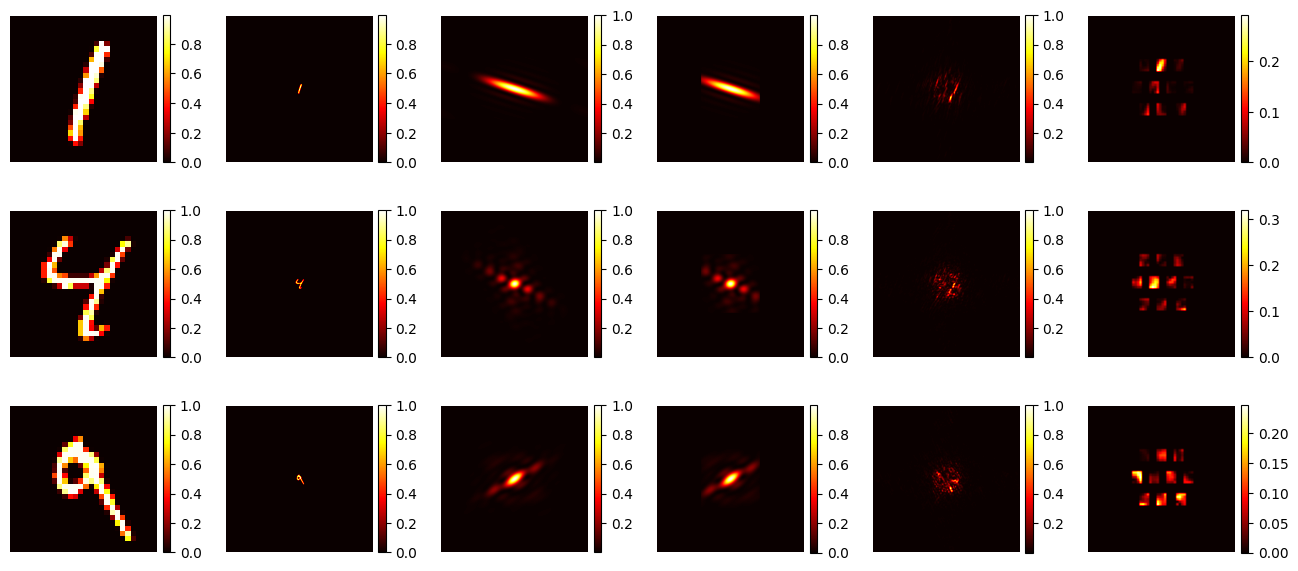

In [61]:
model.summary()
testImages = np.array([x_test[i] for i in [5,6,7]])
planes     = [0,1,3,4,5]
plotFields(model, testImages, planes,  detector,  zoom = 120)